In [ ]:
# # Imports and Global Settings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr, mannwhitneyu

# Set style for plots
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (18, 10)

In [2]:
# Data Loading
def load_data(tweets_path='all_tweets_annotated_pythia.parquet', candles_path='solana_EwUU8oiKTomjekU5eszctx3kneKJnKm5BJpn5sTT4CUf.csv'):
    tweet_df = pd.read_parquet(tweets_path)
    candle_df = pd.read_csv(candles_path)
    print("Tweets data loaded:", tweet_df.shape)
    print("Candles data loaded:", candle_df.shape)
    return tweet_df, candle_df
    
tweet_df, candle_df = load_data()

Tweets data loaded: (4265, 13)
Candles data loaded: (97763, 6)


In [3]:
# Basic Preprocessing
def preprocess_data(tweet_df, candle_df):
    tweet_df['timestamp'] = pd.to_datetime(tweet_df['timestamp']).dt.tz_localize(None)
    candle_df['timestamp'] = pd.to_datetime(candle_df['timestamp']).dt.tz_localize(None)
    tweet_df_timed = tweet_df[
    (tweet_df['timestamp'] >= candle_df['timestamp'].min()) &
    (tweet_df['relevance_score_t'] > 0.9)
    ].copy()
    return tweet_df_timed, candle_df
    
tweet_df_timed, candle_df = preprocess_data(tweet_df, candle_df)

In [4]:
# Calculate Base Hype Metrics
def calculate_hype_metrics(df):
    df['impact_score'] = (
    df['reposts'] * 5 +
    df['likes'] * 2 +
    df['views'] * 0.1
    )
    df['weighted_hype_index'] = (
    (df['promo_score_x'] + df['emotion_score_z'].abs()) *
    df['impact_score']
    )
    df.set_index('timestamp', inplace=True)
    tweet_agg_df = df[['weighted_hype_index']].resample('1T').sum()
    return tweet_agg_df
tweet_agg_df = calculate_hype_metrics(tweet_df_timed)

/var/folders/99/7qdg8pf565598f95py8lb3480000gn/T/ipykernel_52310/462376302.py:13: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  tweet_agg_df = df[['weighted_hype_index']].resample('1T').sum()


In [5]:
# Process Candles and Merge Datasets
def process_and_merge(candle_df, tweet_agg_df):
    candle_df['price_change_pct'] = candle_df['close'].pct_change() * 100
    candle_df.set_index('timestamp', inplace=True)
    combined_df = candle_df.merge(tweet_agg_df, left_index=True, right_index=True, how='left')
    combined_df['weighted_hype_index'].fillna(0, inplace=True)
    return combined_df
    
combined_df = process_and_merge(candle_df, tweet_agg_df)
df_processed = combined_df.copy()  # Consistent naming

/var/folders/99/7qdg8pf565598f95py8lb3480000gn/T/ipykernel_52310/3720451364.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined_df['weighted_hype_index'].fillna(0, inplace=True)


In [6]:
# Handle Outliers and Normalize Hype
def normalize_hype(df, quantile=0.999):
    print(df['weighted_hype_index'].value_counts())
    quantile_99 = df['weighted_hype_index'].quantile(quantile)
    print(f"Outlier threshold (99th percentile): {quantile_99:.2f}")
    df['hype_clipped'] = df['weighted_hype_index'].clip(upper=quantile_99)
    min_val = df['hype_clipped'].min()
    max_val = df['hype_clipped'].max()
    if max_val > min_val:
        df['hype_normalized_pct'] = (df['hype_clipped'] - min_val) / (max_val - min_val) * 100
    else:
        df['hype_normalized_pct'] = 0
    print(f"New 'Hype Index' range: {df['hype_normalized_pct'].min():.2f}% to {df['hype_normalized_pct'].max():.2f}%")
    return df
    
df_processed = normalize_hype(df_processed)

weighted_hype_index
0.000        96928
9.306            2
20.770           2
6.900            2
19.019           1
             ...  
7.956            1
10510.905        1
39.875           1
93.075           1
265.907          1
Name: count, Length: 833, dtype: int64
Outlier threshold (99th percentile): 3177.51
New 'Hype Index' range: 0.00% to 100.00%


In [7]:
# Calculate Advanced Metrics
def calculate_advanced_metrics(df, tweet_df_timed, window='30T'):
    df['hype_momentum'] = df['hype_normalized_pct'].rolling(window=window).mean()
    df['hype_acceleration'] = df['hype_momentum'].pct_change(periods=5) * 100
    df.replace([np.inf, -np.inf], 0, inplace=True)
    author_counts = tweet_df_timed.resample('1T').agg({'author_username': 'nunique'})
    author_counts.rename(columns={'author_username': 'unique_authors'}, inplace=True)
    df = df.merge(author_counts, left_index=True, right_index=True, how='left')
    df['unique_authors'].fillna(0, inplace=True)
    df['author_velocity'] = df['unique_authors'].rolling(window=window).sum()
    print("Created metrics: 'hype_momentum', 'hype_acceleration', 'author_velocity'")
    return df

WINDOW = '30T'
df_processed = calculate_advanced_metrics(df_processed, tweet_df_timed, WINDOW)

Created metrics: 'hype_momentum', 'hype_acceleration', 'author_velocity'


/var/folders/99/7qdg8pf565598f95py8lb3480000gn/T/ipykernel_52310/434294890.py:3: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df['hype_momentum'] = df['hype_normalized_pct'].rolling(window=window).mean()
/var/folders/99/7qdg8pf565598f95py8lb3480000gn/T/ipykernel_52310/434294890.py:6: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  author_counts = tweet_df_timed.resample('1T').agg({'author_username': 'nunique'})
/var/folders/99/7qdg8pf565598f95py8lb3480000gn/T/ipykernel_52310/434294890.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value},

In [8]:
# Find Key Events
def find_key_events(df, price_window='30min'):
    price_change = df['close'].rolling(window=price_window).apply(lambda x: x.iloc[-1] - x.iloc[0])
    time_of_max_change = price_change.abs().idxmax()
    print(f"Max price change in {price_window} at: {time_of_max_change}")
    max_momentum_time = df['hype_momentum'].idxmax()
    time_delta = pd.Timedelta(hours=1)
    zoom_start_time = max_momentum_time - time_delta
    zoom_end_time = max_momentum_time + time_delta
    return time_of_max_change, max_momentum_time, zoom_start_time, zoom_end_time
    
PRICE_CHANGE_WINDOW = '30min'
time_of_max_change, max_momentum_time, zoom_start_time, zoom_end_time = find_key_events(df_processed, PRICE_CHANGE_WINDOW)

Max price change in 30min at: 2025-07-23 12:17:00


In [ ]:
# Plot Hype Metrics
def plot_hype_metrics(df, zoom_start, zoom_end, max_momentum_time, window='30T'):
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(20, 18), gridspec_kw={'height_ratios': [2, 1, 1]})
    ##Price
    ax1.plot(df.index, df['close'], color='black', label='Close Price')
    ax1.set_title('Token Price $PYTHIA', fontsize=16)
    ax1.set_ylabel('Price, USD')
    ax1.legend()
    ax1.grid(True, linestyle='--')
    ax1.axvline(max_momentum_time, color='red', linestyle='--', linewidth=2, label='Momentum Peak')
    ax1.legend()
    ##Momentum and Acceleration
    ax2_twin = ax2.twinx()
    ax2.plot(df.index, df['hype_momentum'], color='cornflowerblue', label=f'Hype Momentum ({window})')
    ax2_twin.bar(df.index, df['hype_acceleration'], width=0.002, color='salmon', alpha=0.6, label='Hype Acceleration (5-min %)')
    ax2.set_title('Hype Dynamics: Momentum and Acceleration', fontsize=16)
    ax2.set_ylabel('Momentum (blue)', color='cornflowerblue')
    ax2_twin.set_ylabel('Acceleration, % (red)', color='salmon')
    ax2.legend(loc='upper left')
    ax2_twin.legend(loc='upper right')
    ax2.grid(True, linestyle='--')
    ax2.axvline(max_momentum_time, color='red', linestyle='--', linewidth=2)
    ##Author Velocity
    ax3.plot(df.index, df['author_velocity'], color='green', label=f'Unique Authors ({window})')
    ax3.set_title('Spread: Author Engagement Velocity', fontsize=16)
    ax3.set_ylabel('Unique Authors Count')
    ax3.set_xlabel('Time', fontsize=12)
    ax3.legend()
    ax3.grid(True, linestyle='--')
    ax3.axvline(max_momentum_time, color='red', linestyle='--', linewidth=2)
    ax1.set_xlim(zoom_start, zoom_end)
    plt.tight_layout()
    plt.show()
    
plot_hype_metrics(df_processed, zoom_start_time, zoom_end_time, time_of_max_change, WINDOW)

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x106ee8610>>
Traceback (most recent call last):
  File "/Users/elisaveta/.pyenv/versions/3.11.13/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [12]:
# Find Surrounding Tweets
def find_surrounding_tweets(target_time, tweets_df, time_column_name='timestamp'):
    if tweets_df.empty:
        print("Tweets DataFrame is empty.")
        return {'before': None, 'after': None}
    tweets_df[time_column_name] = pd.to_datetime(tweets_df[time_column_name])
    before_df = tweets_df[tweets_df[time_column_name] <= target_time]
    after_df = tweets_df[tweets_df[time_column_name] > target_time]
    tweet_before = None
    tweet_after = None
    print(f"--- Search around time: {target_time.strftime('%Y-%m-%d %H:%M:%S')} ---")

    if not before_df.empty:
        tweet_before = before_df.loc[before_df[time_column_name].idxmax()]
        time_diff = target_time - tweet_before[time_column_name]
        print(f"\nClosest tweet BEFORE:")
        print(f"  Tweet time: {tweet_before[time_column_name].strftime('%Y-%m-%d %H:%M:%S')} ({time_diff} before event)")
        print(f"  Author: {tweet_before.get('author_username', 'N/A')}")
        print(f"  Text: {tweet_before.get('text', 'N/A')}")
    if not after_df.empty:
        tweet_after = after_df.loc[after_df[time_column_name].idxmin()]
        time_diff = tweet_after[time_column_name] - target_time
        print(f"\nClosest tweet AFTER:")
        print(f"  Tweet time: {tweet_after[time_column_name].strftime('%Y-%m-%d %H:%M:%S')} ({time_diff} after event)")
        print(f"  Author: {tweet_after.get('author_username', 'N/A')}")
        print(f"  Text: {tweet_after.get('text', 'N/A')}")
        
    return {'before': tweet_before, 'after': tweet_after}

surrounding_tweets = find_surrounding_tweets(time_of_max_change, tweet_df, 'timestamp')
if surrounding_tweets['before'] is not None:
    print("\n--- 'BEFORE' Tweet Data (Series) ---")
    print(surrounding_tweets['before']['text'])
if surrounding_tweets['after'] is not None:
    print("\n--- 'AFTER' Tweet Data (Series) ---")
    print(surrounding_tweets['after']['text'])

--- Search around time: 2025-07-23 12:17:00 ---

Closest tweet BEFORE:
  Tweet time: 2025-07-23 11:56:26 (0 days 00:20:34 before event)
  Author: 0x777c
  Text: BUY DIP

BUY FEAR 

BUY BLOOD

 $PYTHIA emerged from the hell of a 2M market cap, I fear nothing

Closest tweet AFTER:
  Tweet time: 2025-07-23 12:33:52 (0 days 00:16:52 after event)
  Author: bigbigorang_yep
  Text: 笑而不语～ $pythia

--- 'BEFORE' Tweet Data (Series) ---
BUY DIP

BUY FEAR 

BUY BLOOD

 $PYTHIA emerged from the hell of a 2M market cap, I fear nothing

--- 'AFTER' Tweet Data (Series) ---
笑而不语～ $pythia


Найдено твитов от пользователя '0x777c': 30


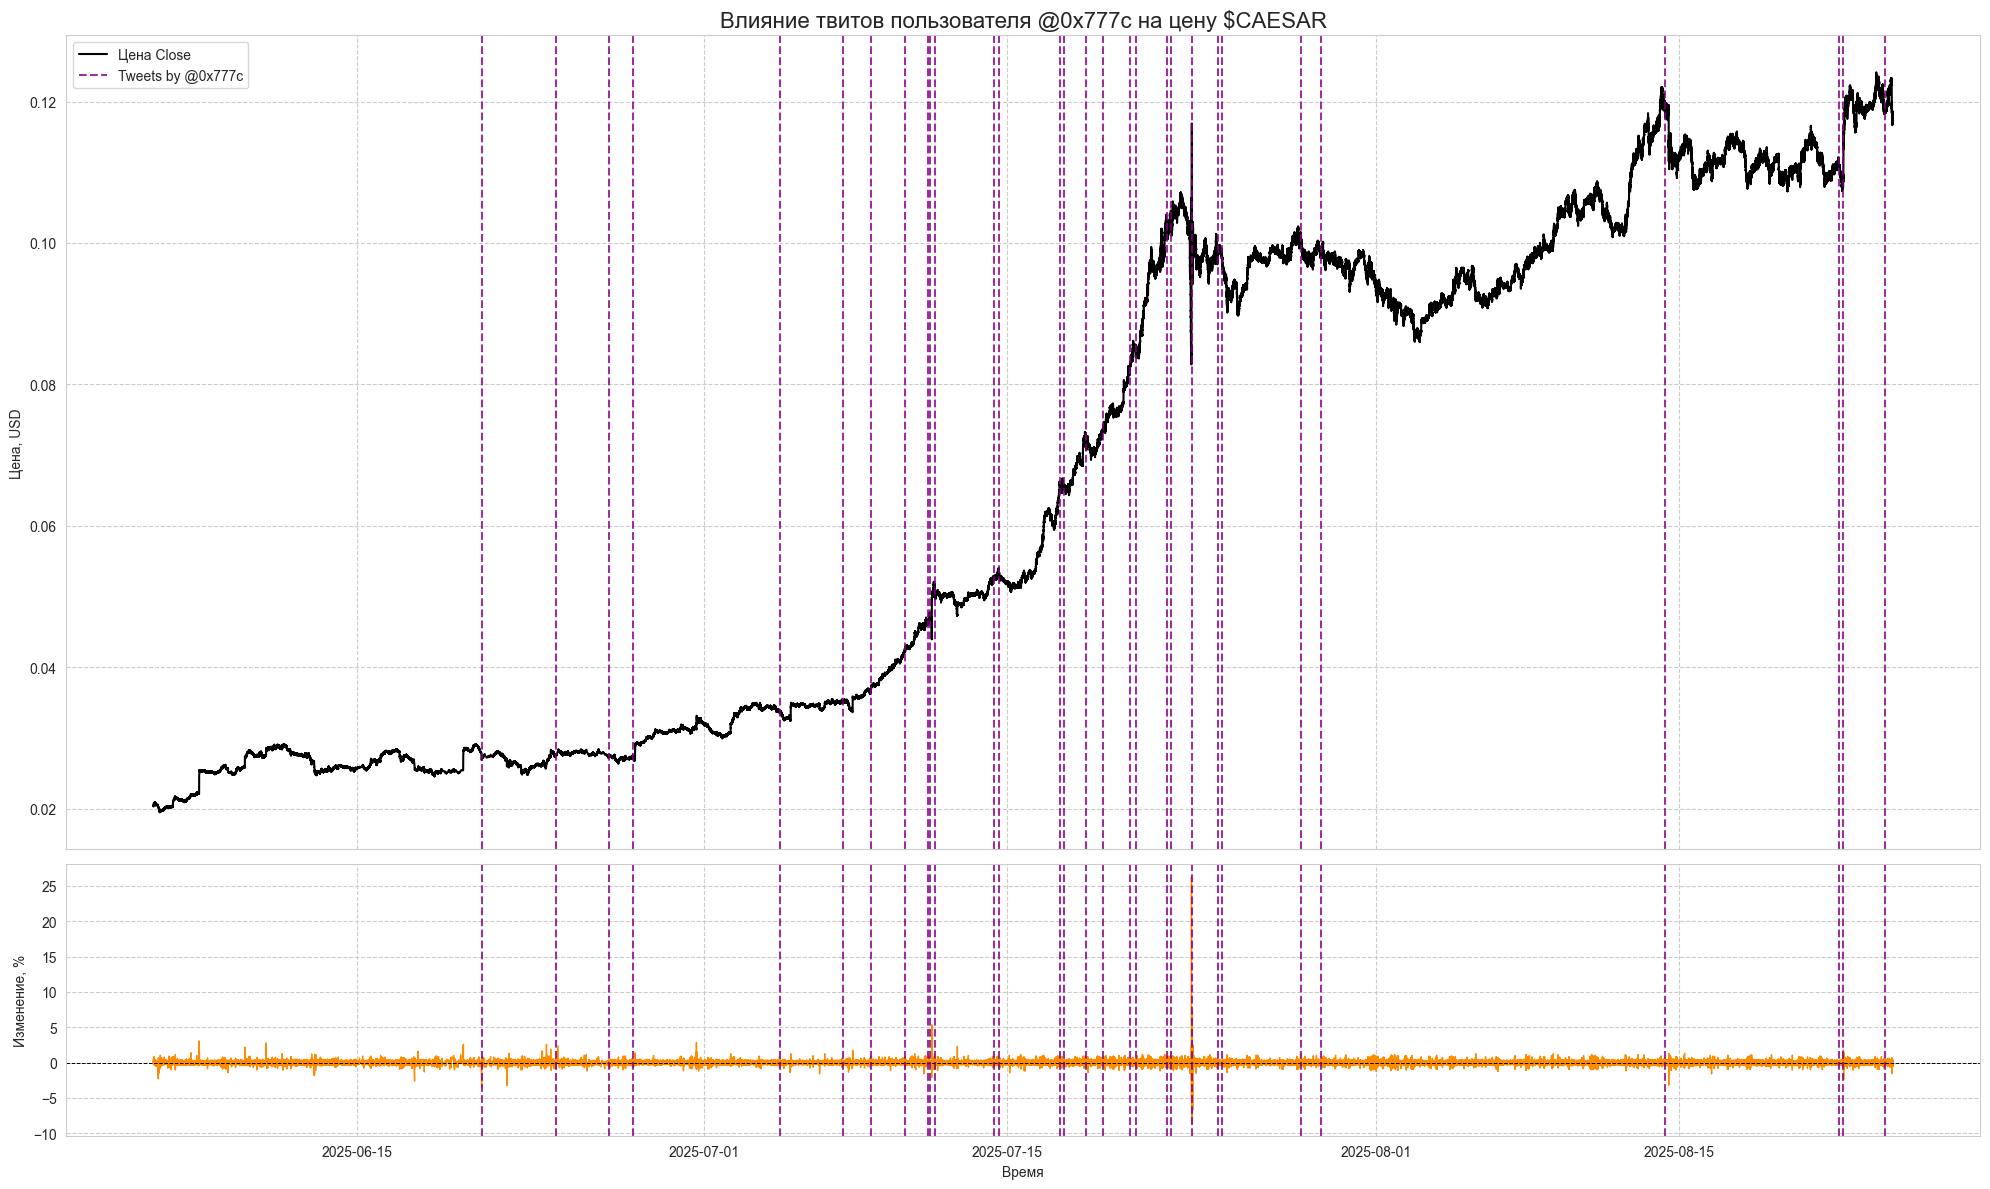


--- Статистический тест влияния @0x777c (окно: 15 мин) ---
Медианный макс. рост после твита: 0.38%
Медианный макс. рост в остальное время: 0.31%
P-value: 0.1104
Результат НЕ является статистически значимым (p >= 0.05).
Наблюдаемый рост после твитов может быть случайностью.

--- Статистический тест влияния @0x777c (окно: 30 мин) ---
Медианный макс. рост после твита: 0.47%
Медианный макс. рост в остальное время: 0.42%
P-value: 0.1889
Результат НЕ является статистически значимым (p >= 0.05).
Наблюдаемый рост после твитов может быть случайностью.

--- Статистический тест влияния @0x777c (окно: 60 мин) ---
Медианный макс. рост после твита: 0.56%
Медианный макс. рост в остальное время: 0.58%
P-value: 0.0777
Результат НЕ является статистически значимым (p >= 0.05).
Наблюдаемый рост после твитов может быть случайностью.

--- Статистический тест влияния @0x777c (окно: 120 мин) ---
Медианный макс. рост после твита: 1.06%
Медианный макс. рост в остальное время: 0.84%
P-value: 0.1556
Результат НЕ

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu

# --- ЧАСТЬ 1: Визуализация влияния (без изменений) ---

def plot_user_impact(username: str, price_df: pd.DataFrame, tweets_df: pd.DataFrame):
    """
    Рисует график цены и отмечает на нем вертикальными линиями моменты твитов указанного пользователя.
    """
    user_tweets = tweets_df[tweets_df['author_username'] == username]
    
    if user_tweets.empty:
        print(f"Пользователь '{username}' не найден в датасете или не писал о токене в данный период.")
        return
        
    print(f"Найдено твитов от пользователя '{username}': {len(user_tweets)}")
    
    fig, (ax1, ax2) = plt.subplots(2, 1, 
                                    sharex=True, 
                                    figsize=(20, 12), 
                                    gridspec_kw={'height_ratios': [3, 1]})
    
    ax1.plot(price_df.index, price_df['close'], color='black', label='Цена Close', zorder=1)
    ax1.set_title(f'Влияние твитов пользователя @{username} на цену $CAESAR', fontsize=16)
    ax1.set_ylabel('Цена, USD')
    ax1.grid(True, linestyle='--')
    
    ax2.plot(price_df.index, price_df['price_change_pct'], color='darkorange', linewidth=1, label='Изменение цены, %')
    ax2.axhline(0, color='black', linewidth=0.7, linestyle='--')
    ax2.set_ylabel('Изменение, %')
    ax2.set_xlabel('Время')
    ax2.grid(True, linestyle='--')
    
    for i, tweet_time in enumerate(user_tweets.index):
        label = f'Tweets by @{username}' if i == 0 else None
        ax1.axvline(x=tweet_time, color='purple', linestyle='--', alpha=0.8, label=label, zorder=2)
        ax2.axvline(x=tweet_time, color='purple', linestyle='--', alpha=0.8)
        
    ax1.legend()
    plt.tight_layout()
    plt.show()

# --- ЧАСТЬ 2: Статистическая проверка влияния (С ИСПРАВЛЕНИЕМ) ---

def test_user_influence(username: str, price_df: pd.DataFrame, tweets_df: pd.DataFrame, time_window_Z: int):
    """
    Использует тест Манна-Уитни для проверки, значимо ли отличаются доходности после твитов 
    пользователя от доходностей в остальное время.
    """
    print(f"\n--- Статистический тест влияния @{username} (окно: {time_window_Z} мин) ---")
    
    user_tweets = tweets_df[tweets_df['author_username'] == username]
    if user_tweets.empty or len(user_tweets) < 3:
        print(f"Недостаточно данных для теста (найдено {len(user_tweets)} твитов).")
        return
        
    tweet_times = user_tweets.index
    
    # === ИСПРАВЛЕНИЕ ЗДЕСЬ ===
    # Создаем копию и удаляем дубликаты в индексе перед любыми операциями
    df = price_df.copy()
    if df.index.has_duplicates:
        df = df[~df.index.duplicated(keep='first')]

    df['future_return'] = (
        df['high'].rolling(window=time_window_Z, min_periods=1).max().shift(-time_window_Z)
        - df['open']
    ) / df['open'] * 100
    df.dropna(subset=['future_return'], inplace=True)
    
    # reindex теперь будет работать на очищенном от дубликатов индексе
    post_tweet_returns = df.reindex(tweet_times, method='nearest')['future_return'].dropna()
    
    baseline_returns = df.loc[~df.index.isin(tweet_times)]['future_return'].dropna()

    if len(post_tweet_returns) < 3:
        print("Недостаточно данных о доходностях после твитов для проведения теста.")
        return

    statistic, p_value = mannwhitneyu(post_tweet_returns, baseline_returns, alternative='greater')
    
    print(f"Медианный макс. рост после твита: {post_tweet_returns.median():.2f}%")
    print(f"Медианный макс. рост в остальное время: {baseline_returns.median():.2f}%")
    print(f"P-value: {p_value:.4f}")
    
    if p_value < 0.05:
        print("РЕЗУЛЬТАТ СТАТИСТИЧЕСКИ ЗНАЧИМ (p < 0.05).")
        print(f"Есть основания полагать, что твиты @{username} положительно влияют на цену в течение {time_window_Z} минут.")
    else:
        print("Результат НЕ является статистически значимым (p >= 0.05).")
        print("Наблюдаемый рост после твитов может быть случайностью.")

# --- ЗАПУСК АНАЛИЗА ---

USERNAME_TO_ANALYZE = '0x777c' # Замени на реальное имя

# Визуальный анализ
plot_user_impact(USERNAME_TO_ANALYZE, df_processed, tweet_df_timed)

# Статистические тесты
for window in [15, 30, 60, 120]:
    test_user_influence(USERNAME_TO_ANALYZE, df_processed, tweet_df_timed, time_window_Z=window) # Пример, замени на реальное имя из твоего датасета

In [17]:
# Backtesting and Statistical Tests
def run_practical_backtest(df, hype_threshold_pct, price_change_target, time_window):
    signal_indices = df[df['hype_normalized_pct'] > hype_threshold_pct].index
    if len(signal_indices) == 0:
        return 0, 0, 0.0
    success_count = 0
    processed_signals = []
    for signal_time in signal_indices:
        if any((signal_time - proc_time).total_seconds() / 60 < time_window for proc_time in processed_signals):
            continue
        window_end = signal_time + pd.Timedelta(minutes=time_window)
        window_df = df.loc[signal_time:window_end]
        if not window_df.empty:
            initial_price = window_df['open'].iloc[0]
            max_price = window_df['high'].max()
            max_change = ((max_price - initial_price) / initial_price) * 100
            if max_change >= price_change_target:
                success_count += 1
        processed_signals.append(signal_time)
    total_signals = len(processed_signals)
    success_rate = (success_count / total_signals) * 100 if total_signals > 0 else 0
    return success_count, total_signals, success_rate

def run_mann_whitney_test(df, hype_threshold_pct, time_window):
    df['future_return'] = (
        df['high'].rolling(window=time_window).max().shift(-time_window)
        - df['open']
    ) / df['open'] * 100

    df_clean = df[['hype_normalized_pct', 'future_return']].dropna()
    hype_returns = df_clean[df_clean['hype_normalized_pct'] > hype_threshold_pct]['future_return']
    baseline_returns = df_clean[df_clean['hype_normalized_pct'] <= hype_threshold_pct]['future_return']
    if len(hype_returns) < 20 or len(baseline_returns) < 20:
        return None, None, None
    statistic, p_value = mannwhitneyu(hype_returns, baseline_returns, alternative='greater')
    return statistic, p_value, (hype_returns.median(), baseline_returns.median())

# Spearman Correlation Test
print("--- Spearman Correlation Test ---")
LOOKAHEAD_MINUTES = 30
df_processed['future_max_return'] = (
    df_processed['high'].rolling(window=LOOKAHEAD_MINUTES).max().shift(-LOOKAHEAD_MINUTES)
    - df_processed['open']
) / df_processed['open'] * 100

corr_df = df_processed[['hype_normalized_pct', 'future_max_return']].dropna()
correlation, p_value_corr = spearmanr(corr_df['hype_normalized_pct'], corr_df['future_max_return'])
print(f"Spearman correlation (hype vs. max growth in {LOOKAHEAD_MINUTES} min): {correlation:.4f}")
print(f"P-value: {p_value_corr:.4f}")
if p_value_corr < 0.05:
    print("SIGNIFICANT: Link between hype and future price growth.")
else:
    print("NOT SIGNIFICANT: Link may be random.")
print("-" * 50)

# Run Experiments
hype_thresholds_pct = [50, 70, 80, 90]
price_targets = [5, 10]
time_windows = [15, 30, 60]
for Z in time_windows:
    print(f"\n===== ANALYSIS FOR {Z} MIN WINDOW =====\n")
    print("--- Practical Backtest Results ---")
    for X_pct in hype_thresholds_pct:
        for Y in price_targets:
            successes, total, rate = run_practical_backtest(df_processed, X_pct, Y, Z)
            if total > 0:
                print(f"Hypothesis: Hype > {X_pct}% -> Growth > {Y}% | Results: {successes}/{total} ({rate:.2f}%)")
    print("\n--- Mann-Whitney Test Results ---")
    for X_pct in hype_thresholds_pct:
        stat, p_val, medians = run_mann_whitney_test(df_processed, X_pct, Z)
        if p_val is not None:
            print(f"Hype threshold > {X_pct}%: p-value = {p_val:.4f}. ", end="")
            if p_val < 0.05:
                print(f"SIGNIFICANT! Median growth: {medians[0]:.2f}% (vs. {medians[1]:.2f}% baseline)")
            else:
                print("NOT SIGNIFICANT.")

--- Spearman Correlation Test ---
Spearman correlation (hype vs. max growth in 30 min): 0.0018
P-value: 0.5802
NOT SIGNIFICANT: Link may be random.
--------------------------------------------------

===== ANALYSIS FOR 15 MIN WINDOW =====

--- Practical Backtest Results ---
Hypothesis: Hype > 50% -> Growth > 5% | Results: 0/144 (0.00%)
Hypothesis: Hype > 50% -> Growth > 10% | Results: 0/144 (0.00%)
Hypothesis: Hype > 70% -> Growth > 5% | Results: 0/118 (0.00%)
Hypothesis: Hype > 70% -> Growth > 10% | Results: 0/118 (0.00%)
Hypothesis: Hype > 80% -> Growth > 5% | Results: 0/111 (0.00%)
Hypothesis: Hype > 80% -> Growth > 10% | Results: 0/111 (0.00%)
Hypothesis: Hype > 90% -> Growth > 5% | Results: 0/107 (0.00%)
Hypothesis: Hype > 90% -> Growth > 10% | Results: 0/107 (0.00%)

--- Mann-Whitney Test Results ---
Hype threshold > 50%: p-value = 0.0506. NOT SIGNIFICANT.
Hype threshold > 70%: p-value = 0.1551. NOT SIGNIFICANT.
Hype threshold > 80%: p-value = 0.1502. NOT SIGNIFICANT.
Hype thresh

In [18]:
# Advanced Checks: Reverse Causality
print("--- Check: Does PRICE Influence Future HYPE? ---")
df_processed['hype_shifted_forward_5T'] = df_processed['hype_normalized_pct'].shift(-5)
df_processed['hype_shifted_forward_15T'] = df_processed['hype_normalized_pct'].shift(-15)
corr_5 = df_processed['price_change_pct'].corr(df_processed['hype_shifted_forward_5T'])
corr_15 = df_processed['price_change_pct'].corr(df_processed['hype_shifted_forward_15T'])
print(f"Correlation (price growth now vs. hype in 5 min): {corr_5:.4f}")
print(f"Correlation (price growth now vs. hype in 15 min): {corr_15:.4f}")
if corr_5 > 0.1 or corr_15 > 0.1:
    print("\nCONCLUSION: Likely REVERSE CAUSALITY. Price growth causes hype.")
else:
    print("\nCONCLUSION: No clear reverse link. Proceed with tweets-to-price analysis.")

--- Check: Does PRICE Influence Future HYPE? ---
Correlation (price growth now vs. hype in 5 min): -0.0009
Correlation (price growth now vs. hype in 15 min): -0.0048

CONCLUSION: No clear reverse link. Proceed with tweets-to-price analysis.


In [19]:
# Advanced Checks: Volatility
print("\n--- Check: Does HYPE Influence VOLATILITY? ---")
df_processed['price_volatility'] = df_processed['price_change_pct'].abs()
df_processed['future_volatility_30T'] = df_processed['price_volatility'].rolling(30).mean().shift(-30)
corr_vol, p_val_vol = spearmanr(df_processed[['hype_normalized_pct', 'future_volatility_30T']].dropna())
print(f"Spearman correlation (hype vs. future volatility in 30 min): {corr_vol:.4f}")
print(f"P-value: {p_val_vol:.4f}")
if p_val_vol < 0.05 and corr_vol > 0:
    print("\nCONCLUSION: SIGNIFICANT! Hype linked to increased future volatility.")
else:
    print("\nCONCLUSION: No significant link to volatility.")


--- Check: Does HYPE Influence VOLATILITY? ---
Spearman correlation (hype vs. future volatility in 30 min): 0.0090
P-value: 0.0049

CONCLUSION: SIGNIFICANT! Hype linked to increased future volatility.


In [20]:
# Advanced Checks: Tweet Type Segmentation
print("\n--- Check: Which TWEET TYPE Influences Price? ---")
tweet_df_timed['shill_index'] = (tweet_df_timed['promo_score_x'] * tweet_df_timed['impact_score']).clip(lower=0)
tweet_df_timed['analytical_index'] = (tweet_df_timed['depth_score_y'] * tweet_df_timed['impact_score']).clip(lower=0)
tweet_df_timed['emotional_index'] = (tweet_df_timed['emotion_score_z'].abs() * tweet_df_timed['impact_score']).clip(lower=0)
shill_agg = tweet_df_timed.resample('1T').agg({'shill_index': 'sum'})
analytical_agg = tweet_df_timed.resample('1T').agg({'analytical_index': 'sum'})
emotional_agg = tweet_df_timed.resample('1T').agg({'emotional_index': 'sum'})
df_processed = df_processed.merge(shill_agg, left_index=True, right_index=True, how='left').fillna(0)
df_processed = df_processed.merge(analytical_agg, left_index=True, right_index=True, how='left').fillna(0)
df_processed = df_processed.merge(emotional_agg, left_index=True, right_index=True, how='left').fillna(0)
for signal_type in ['shill_index', 'analytical_index', 'emotional_index']:
    corr, p_val = spearmanr(df_processed[[signal_type, 'future_max_return']].dropna())
    print(f"Correlation for '{signal_type}': {corr:.4f} (p-value: {p_val:.4f})")


--- Check: Which TWEET TYPE Influences Price? ---


/var/folders/99/7qdg8pf565598f95py8lb3480000gn/T/ipykernel_52310/693385624.py:6: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  shill_agg = tweet_df_timed.resample('1T').agg({'shill_index': 'sum'})
/var/folders/99/7qdg8pf565598f95py8lb3480000gn/T/ipykernel_52310/693385624.py:7: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  analytical_agg = tweet_df_timed.resample('1T').agg({'analytical_index': 'sum'})
/var/folders/99/7qdg8pf565598f95py8lb3480000gn/T/ipykernel_52310/693385624.py:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  emotional_agg = tweet_df_timed.resample('1T').agg({'emotional_index': 'sum'})


Correlation for 'shill_index': 0.0013 (p-value: 0.6874)
Correlation for 'analytical_index': 0.0012 (p-value: 0.7172)
Correlation for 'emotional_index': 0.0013 (p-value: 0.6869)


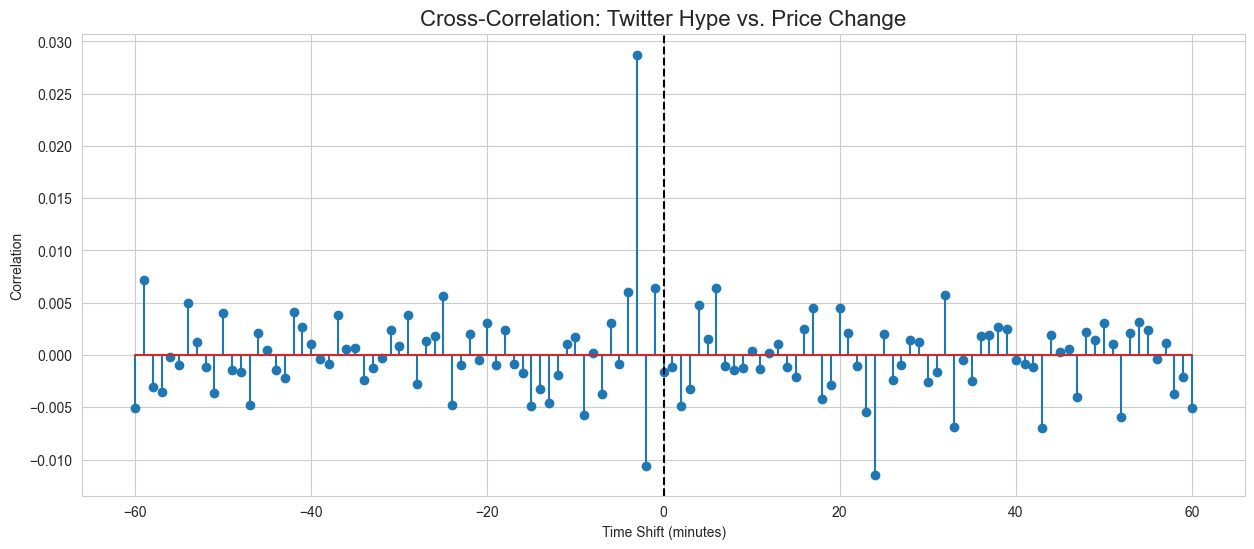

In [21]:
# Advanced Checks: Cross-Correlation
lags = range(-60, 61)
correlations = [df_processed['price_change_pct'].corr(df_processed['hype_normalized_pct'].shift(lag)) for lag in lags]
plt.figure(figsize=(15, 6))
plt.stem(lags, correlations)
plt.title('Cross-Correlation: Twitter Hype vs. Price Change', fontsize=16)
plt.xlabel('Time Shift (minutes)')
plt.ylabel('Correlation')
plt.grid(True)
plt.axvline(0, color='black', linestyle='--')
plt.show()